In [1]:
from __future__ import annotations

import pathlib
import re
from collections import defaultdict
from datetime import datetime

import polars
import seaborn
from matplotlib import pyplot as plt

_ = polars.Config.set_tbl_rows(100)

In [2]:
def load_events(logs: list[pathlib.Path]) -> polars.DataFrame:
    event_lines = []
    for log in logs:
        with open(log) as f:
            for line in f:
                if 'START' in line or 'END' in line:
                    event_lines.append(line)

    log_pattern = re.compile(
        r'\[(?P<timestamp>[\d\-:\. ]+)\] .*?\b(?P<event_type>START|END)\b (?P<task>\S+) (?P<uuid>[a-f0-9\-]{36})',
    )
    events = []
    for line in event_lines:
        matches = log_pattern.search(line)
        if matches:
            data = matches.groupdict()
            # Optionally, parse timestamp string to a datetime object
            data['timestamp'] = datetime.strptime(
                data['timestamp'],
                '%Y-%m-%d %H:%M:%S.%f',
            )
            events.append(data)

    df = polars.from_dicts(events)
    df = df.with_columns(
        [
            (
                (
                    polars.col('timestamp') - polars.col('timestamp').min()
                ).dt.total_milliseconds()
                / 1000
                / 60
            ).alias('timestamp'),
        ],
    ).sort('timestamp')
    df = (
        df.group_by(['uuid', 'task'])
        .agg(
            [
                polars.col('timestamp')
                .filter(polars.col('event_type') == 'START')
                .alias('start'),
                polars.col('timestamp')
                .filter(polars.col('event_type') == 'END')
                .alias('end'),
            ],
        )
        .drop('uuid')
        .with_columns(
            [
                polars.col('start').list.first(),
                polars.col('end').list.first(),
            ],
        )
        .with_columns(polars.col('end').fill_null(polars.col('start').max()))
        .sort(['start', 'end'])
        .with_columns(
            (polars.col('end') - polars.col('start'))
            .clip(0)
            .alias('duration'),
        )
    )
    return df

In [3]:
def partition_events_tiled(task_events, task_workers):
    all_events = {}
    for task, events in task_events.items():
        num_workers = task_workers[task]
        worker_events = {i: [] for i in range(num_workers)}
        for event in events:
            corrected = (event[0], max(0, event[1] - event[0]))
            for worker in worker_events:
                if len(worker_events[worker]) == 0:
                    worker_events[worker].append(corrected)
                    break
                # There is some asynchronicity in logging the end of a task so we assumed two tasks
                # could've run on the same worker if the are within 1 ms end time of each other.
                prior_end = (
                    worker_events[worker][-1][0] + worker_events[worker][-1][1]
                ) - 0.001
                if prior_end < event[0]:
                    worker_events[worker].append(corrected)
                    break
            else:
                print('BAD', task, event)
        all_events[task] = worker_events
    return all_events

In [4]:
def partition_events_stacked(task_events, task_workers):
    all_events = {}
    for task, events in task_events.items():
        num_workers = task_workers[task]
        worker_events = {i: [] for i in range(num_workers)}
        sorted_events = sorted(events, key=lambda e: (e[0], e[1]))
        last_worker = 0
        for event in sorted_events:
            corrected = (event[0], max(0, event[1] - event[0]))
            worker_events[last_worker].append(corrected)
            last_worker = (last_worker + 1) % num_workers
        all_events[task] = worker_events
    return all_events

In [12]:
def plot_gantt(
    raw,
    partitioned_events,
    structures_per_task,
    filename,
    counts=True,
) -> None:
    fig, axs = plt.subplots(1, 1)

    colors = {
        'generate-ligands': '#4D3886',
        'assemble-mofs': '#E68310',
        'validate-structures': '#3969AC',
        'retrain': '#F2B701',
        'optimize-cells': '#11A579',
        'estimate-adsorption': '#D64269',
    }

    label_index = {}
    sep_bars = []
    next_index = 0
    for task in partitioned_events:
        for worker in partitioned_events[task]:
            label_index[(task, worker)] = next_index
            next_index += 1
        # Add space between types
        if task in [
            'retrain',
            'assemble-mofs',
            'validate-structures',
            'optimize-cells',
        ]:
            sep_bars.append(next_index)
            next_index += 1

    max_x, max_y = (raw['end'].max(), len(label_index) + len(sep_bars))

    for task in partitioned_events:
        for worker, events in partitioned_events[task].items():
            index = label_index[(task, worker)]
            axs.broken_barh(
                events,
                (index, 0.75),
                facecolor=colors[task],
                label=task,
            )

    for y in sep_bars:
        # axs.broken_barh([(0, max_x)], (y+0.5, 0.25), facecolor='black')
        axs.axhline(y + 0.5, xmin=0, xmax=max_x, linewidth=0.5, color='black')

    axs.grid(False)
    axs.set(
        ylim=[-0.5, max_y + 0.5],
        xlim=[0, max_x],
        xlabel='Runtime (minutes)',
    )

    axs.set_yticks(
        [3, 11, 28, 43, 47],
        labels=[
            'Generator',
            'Assembler',
            'Validator',
            'Optimizer',
            'Estimator',
        ],
    )
    axs.tick_params('y', length=0, width=0, which='major')

    if counts:
        task_counts = {
            'Generator (inference)': sum(
                len(events)
                for events in partitioned_events['generate-ligands'].values()
            ),
            'Generator (training)': sum(
                len(events)
                for events in partitioned_events['retrain'].values()
            ),
            'Assembler': sum(
                len(events)
                for events in partitioned_events['assemble-mofs'].values()
            ),
            'Validator': sum(
                len(events)
                for events in partitioned_events[
                    'validate-structures'
                ].values()
            ),
            'Optimizer': sum(
                len(events)
                for events in partitioned_events['optimize-cells'].values()
            ),
            'Estimator': sum(
                len(events)
                for events in partitioned_events[
                    'estimate-adsorption'
                ].values()
            ),
        }
        structure_counts = {
            k: v * structures_per_task[k]
            if isinstance(structures_per_task[k], int)
            else 'N/A'
            for k, v in task_counts.items()
        }
        # task_str = r'$\bf{Task}$ $\bf{Counts}$' + '\n' + '\n'.join(f'{k}: {structure_counts[k]} | {v}' for k, v in task_counts.items())
        task_str = (
            r'$\bf{Task}$ $\bf{Counts}$'
            + '\n'
            + '\n'.join(f'{k}: {v}' for k, v in task_counts.items())
        )
        # axs.text(2500, 18.4, task_str, fontsize=5, alpha=1, bbox={'boxstyle': 'round', 'alpha': 0.8, 'facecolor': '#F8F8F8', 'edgecolor': '#DFDFDF', 'pad': 0.4})
        axs.text(
            1.02,
            0.25,
            task_str,
            transform=axs.transAxes,
            fontsize=6,
            alpha=1,
            bbox={
                'boxstyle': 'round',
                'alpha': 0.8,
                'facecolor': 'white',
                'edgecolor': '#DFDFDF',
                'pad': 0.4,
            },
        )

    fig.tight_layout()
    plt.draw()
    fig.set_size_inches(7, 1.5)
    fig.savefig(filename)

In [13]:
task_names = [
    'generate-ligands',
    'retrain',
    'assemble-mofs',
    'validate-structures',
    'optimize-cells',
    'estimate-adsorption',
]


def load_and_plot(
    directory,
    task_workers,
    structures_per_task,
    filename,
    stacked=False,
    counts=True,
):
    raw = load_events(list(pathlib.Path(directory).glob('*.txt')))
    task_events = {
        name: raw.filter(polars.col('task') == name)
        .select('start', 'end')
        .rows()
        for name in task_names
    }
    if stacked:
        partitioned = partition_events_stacked(task_events, task_workers)
    else:
        partitioned = partition_events_tiled(task_events, task_workers)
    plot_gantt(raw, partitioned, structures_per_task, filename, counts=counts)

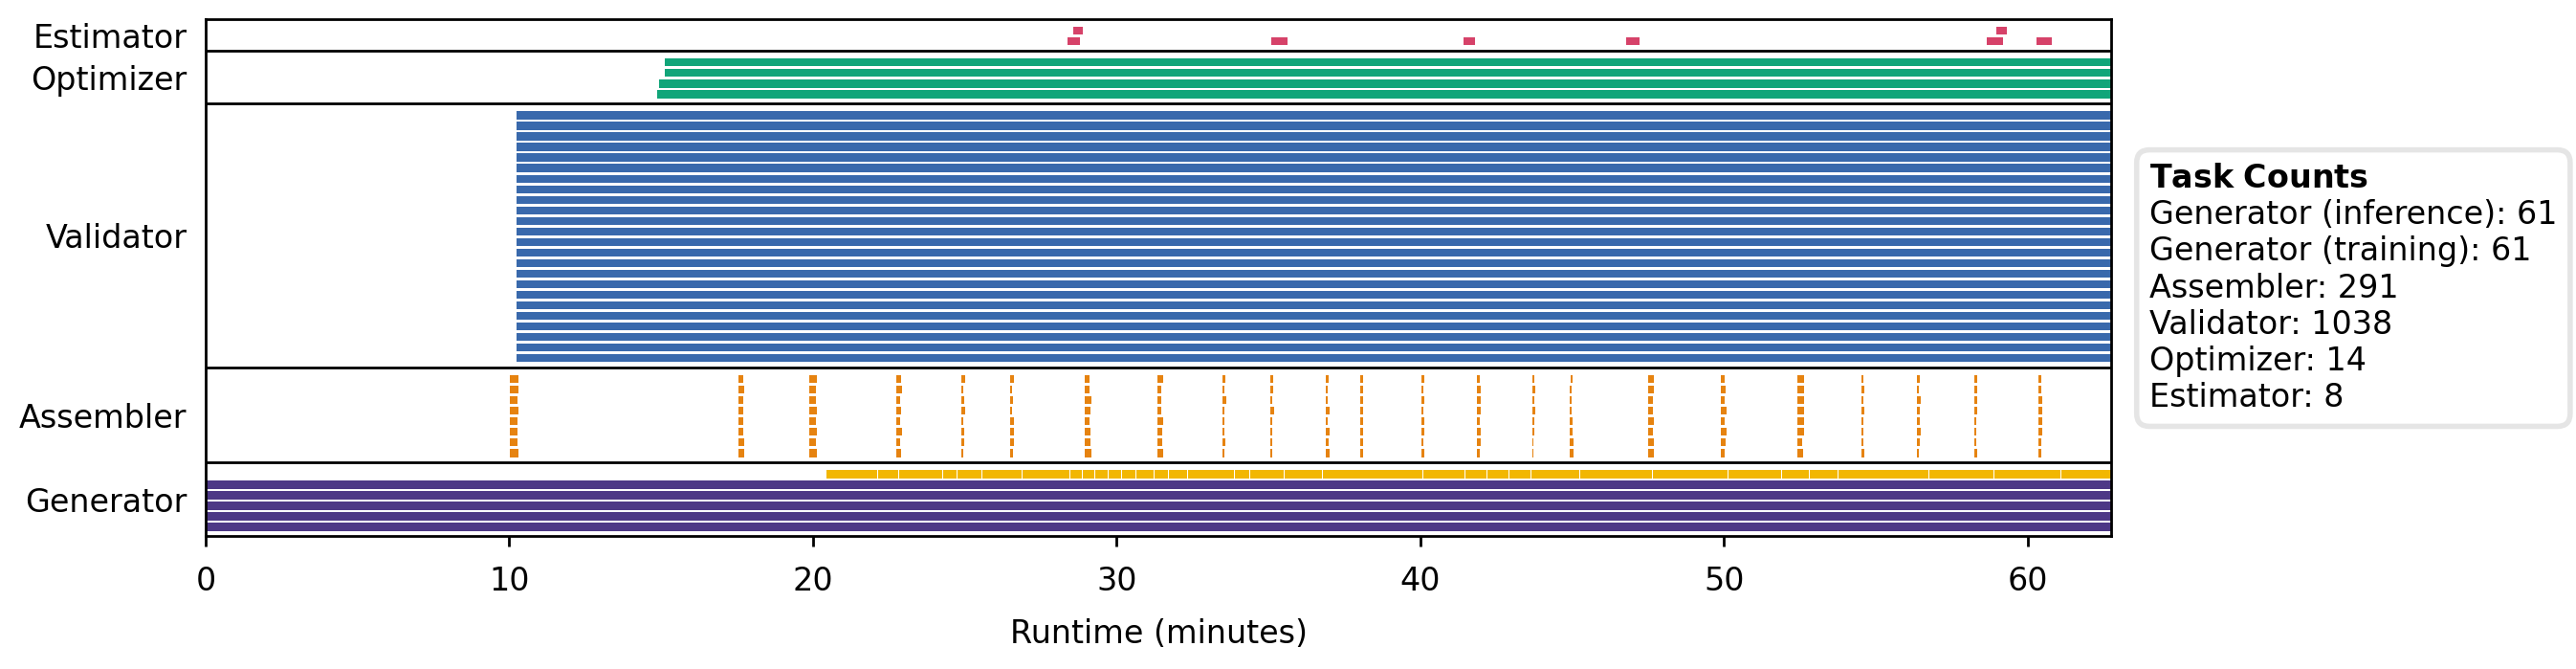

In [14]:
task_workers = {
    'generate-ligands': 5,
    'retrain': 1,
    'assemble-mofs': 8,
    'validate-structures': 24,
    'optimize-cells': 4,
    'estimate-adsorption': 2,
}
structures_per_task = {
    'Generator (inference)': 512,
    'Generator (training)': 'N/A',
    'Assembler': 28,
    'Validator': 1,
    'Optimizer': 1,
    'Estimator': 1,
}
load_and_plot(
    '../data/mofa/29Mar25222227/',
    task_workers,
    structures_per_task,
    'figures/mofa-gantt-small.pdf',
)

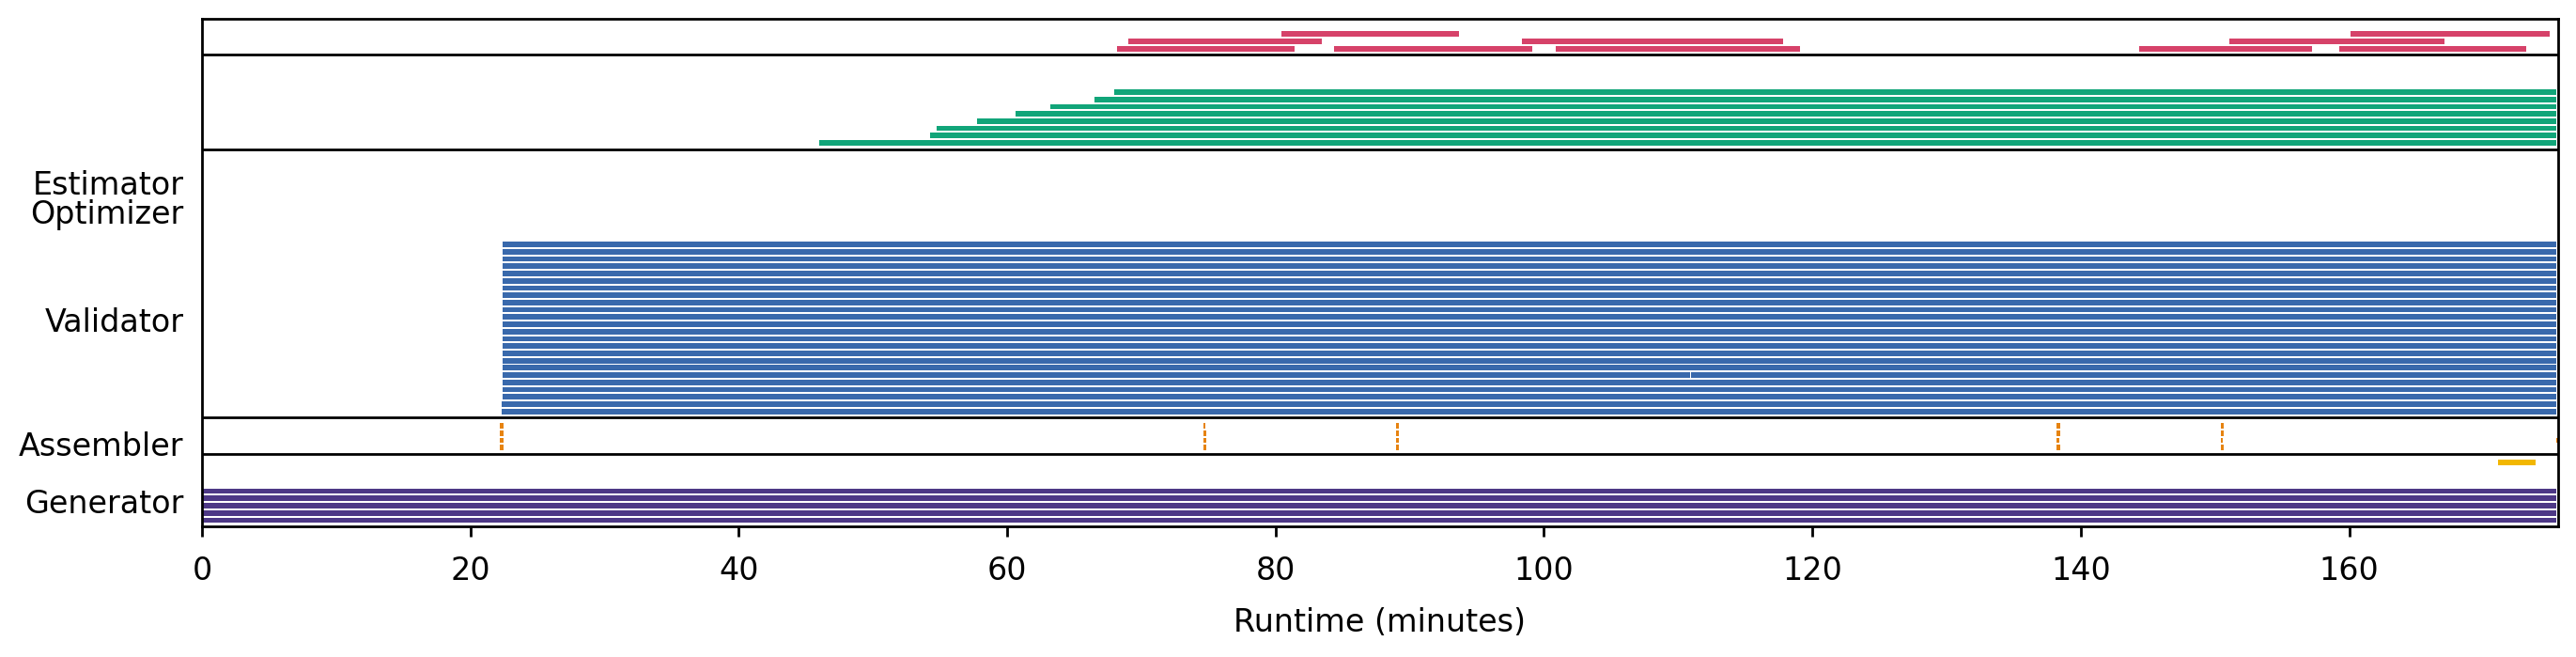

In [15]:
task_workers = {
    'generate-ligands': 8,
    'retrain': 1,
    'assemble-mofs': 4,
    'validate-structures': 36,
    'optimize-cells': 12,
    'estimate-adsorption': 4,
}
structures_per_task = {
    'Generator (inference)': 1024,
    'Generator (training)': 'N/A',
    'Assembler': 28,
    'Validator': 1,
    'Optimizer': 1,
    'Estimator': 1,
}
load_and_plot(
    '../data/mofa/01Apr25144707/',
    task_workers,
    structures_per_task,
    'figures/mofa-gantt-large.pdf',
    stacked=False,
    counts=False,
)

In [26]:
def load_blocks(
    log: pathlib.Path,
    length: int,
    workers_per_block,
) -> polars.DataFrame:
    event_lines = []
    with open(log) as f:
        for line in f:
            if 'Scaling out by' in line:
                event_lines.append(line)

    log_pattern = re.compile(
        r'\[(?P<timestamp>[\d\-:. ]+)\].*?Scaling out by (?P<blocks>\d+) blocks',
    )
    events = []
    for line in event_lines:
        matches = log_pattern.search(line)
        if matches:
            data = matches.groupdict()
            blocks = int(data.pop('blocks'))
            if blocks == 0:
                continue
            # Optionally, parse timestamp string to a datetime object
            data['start'] = (
                datetime.strptime(
                    data.pop('timestamp'),
                    '%Y-%m-%d %H:%M:%S.%f',
                ).timestamp()
                / 60
            )
            data['end'] = data['start'] + length
            data['workers'] = blocks * workers_per_block
            events.append(data)

    return events


def load_tasks(logs: list[pathlib.Path]) -> polars.DataFrame:
    event_lines = []
    for log in logs:
        with open(log) as f:
            for line in f:
                if 'START' in line or 'END' in line:
                    event_lines.append(line)

    log_pattern = re.compile(
        r'\[(?P<timestamp>[\d\-:\. ]+)\] .*?\b(?P<event_type>START|END)\b (?P<task>\S+) (?P<uuid>[a-f0-9\-]{36})',
    )
    events = []
    for line in event_lines:
        matches = log_pattern.search(line)
        if matches:
            data = matches.groupdict()
            if data['event_type'] != 'START':
                continue
            # Optionally, parse timestamp string to a datetime object
            data['timestamp'] = (
                datetime.strptime(
                    data['timestamp'],
                    '%Y-%m-%d %H:%M:%S.%f',
                ).timestamp()
                / 60
            )
            events.append(data)

    cumulative = []
    task_to_agent = {
        'generate-ligands': 'Generator',
        'retrain': 'Generator',
        'assemble-mofs': 'Assembler',
        'validate-structures': 'Validator',
        'optimize-cells': 'Optimizer',
        'estimate-adsorption': 'Estimator',
    }
    submitted_tasks = defaultdict(int)
    for event in events:
        agent = task_to_agent[event['task']]
        submitted_tasks[agent] += 1
        cumulative.append(
            {
                'agent': agent,
                'tasks': submitted_tasks[agent],
                'timestamp': event['timestamp'],
            },
        )
    return polars.from_dicts(cumulative)

In [27]:
directory = pathlib.Path('../data/mofa/01Apr25144707/')
logs = list(directory.glob('*.txt'))

raw_events = load_events(logs)
task_events = {
    name: raw_events.filter(polars.col('task') == name)
    .select('start', 'end')
    .rows()
    for name in [
        'generate-ligands',
        'assemble-mofs',
        'validate-structures',
        'optimize-cells',
        'estimate-adsorption',
    ]
}
task_workers = {
    'generate-ligands': 5,
    'retrain': 1,
    'assemble-mofs': 4,
    'validate-structures': 24,
    'optimize-cells': 8,
    'estimate-adsorption': 4,
}
partitioned_events = partition_events_tiled(task_events, task_workers)

cumulative = load_tasks(logs)

resources = {
    'generator': [
        b
        for i, b in enumerate(
            load_blocks(directory / 'log-main.txt', 60, 6),
        )
        if i % 2 == 0
    ],
    # Drop first event b/c I forgot to set init blocks to 0
    'assembler': load_blocks(directory / 'log-assembler.txt', 5, 4)[1:],
    'validator': [
        b
        for i, b in enumerate(
            load_blocks(directory / 'log-main.txt', 60, 24),
        )
        if i % 2 == 1
    ],
    'optimizer': load_blocks(directory / 'log-optimizer.txt', 60, 8),
    # Drop first event b/c I forgot to set init blocks to 0
    'estimator': load_blocks(directory / 'log-estimator.txt', 60, 4)[1:],
}

events = []
for agent in resources:
    agent_events = resources[agent]
    for event in agent_events:
        events.append(
            {'agent': agent, 'time': event['start'] - 0.001, 'workers': 0},
        )
        events.append(
            {
                'agent': agent,
                'time': event['start'],
                'workers': event['workers'],
            },
        )
        events.append(
            {
                'agent': agent,
                'time': event['end'],
                'workers': event['workers'],
            },
        )
        events.append(
            {'agent': agent, 'time': event['end'] + 0.001, 'workers': 0},
        )
events = polars.from_dicts(events).with_columns(
    [
        polars.col('time') - cumulative['timestamp'].min(),
        polars.col('agent').str.to_titlecase(),
    ],
)
cumulative = cumulative.with_columns(
    (polars.col('timestamp') - polars.col('timestamp').min()).alias('time'),
)

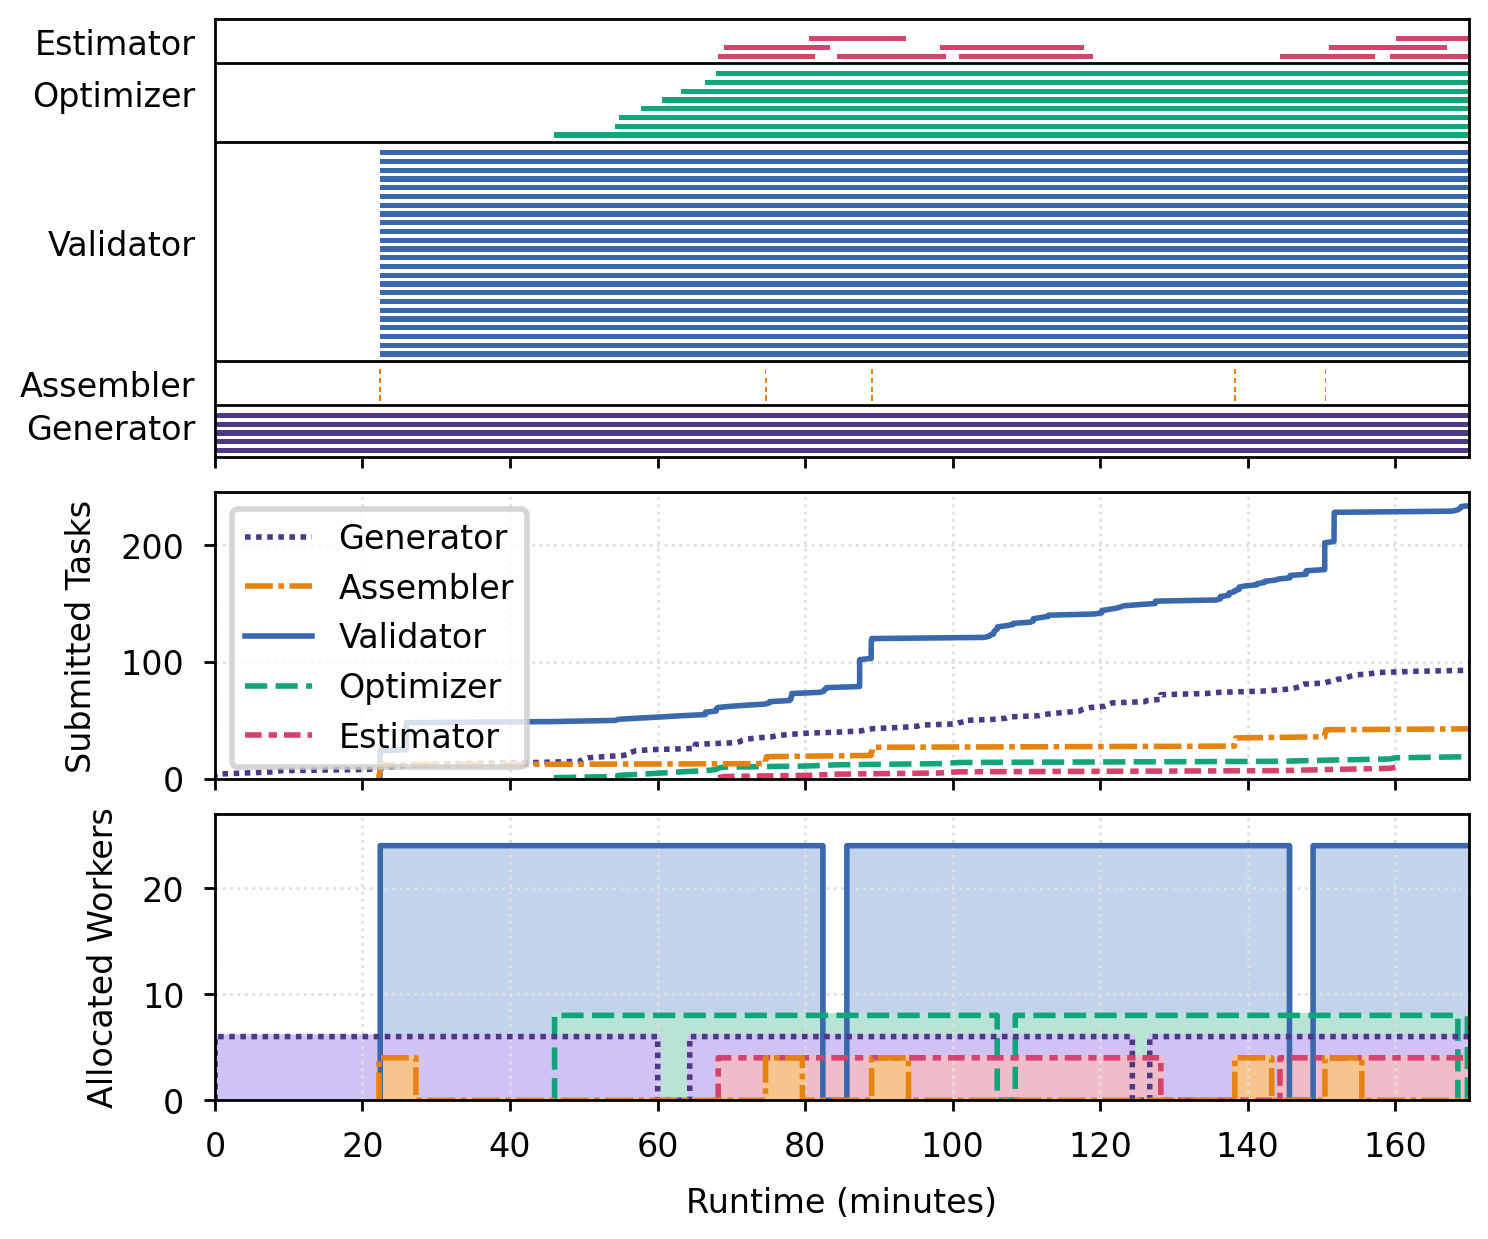

In [31]:
fig, axs = plt.subplots(
    3,
    1,
    sharex=True,
    gridspec_kw={'height_ratios': [1.3, 0.85, 0.85]},
)

# agents = ['Generator', 'Assembler', 'Validator', 'Optimizer', 'Estimator']
agent_order = ['Validator', 'Optimizer', 'Generator', 'Estimator', 'Assembler']
agent_colors = {
    'Generator': '#4D3886',
    'Assembler': '#E68310',
    'Validator': '#3969AC',
    # 'retrain': '#F2B701',
    'Optimizer': '#11A579',
    'Estimator': '#D64269',
}
task_colors = {
    'generate-ligands': '#4D3886',
    'assemble-mofs': '#E68310',
    'validate-structures': '#3969AC',
    'retrain': '#F2B701',
    'optimize-cells': '#11A579',
    'estimate-adsorption': '#D64269',
}
secondary = {
    'Generator': '#D0C2F4',
    'Assembler': '#F6C58D',
    'Validator': '#C2D3EB',
    'Optimizer': '#B8E4D7',
    'Estimator': '#F0BCC9',
}

label_index = {}
sep_bars = []
next_index = 0
for i, task in enumerate(partitioned_events):
    for worker in partitioned_events[task]:
        label_index[(task, worker)] = next_index
        next_index += 1
    if i + 1 < len(partitioned_events):
        sep_bars.append(next_index)
        next_index += 1

max_x, max_y = (170, len(label_index) + len(sep_bars))

for task in partitioned_events:
    for worker, task_events in partitioned_events[task].items():
        index = label_index[(task, worker)]
        axs[0].broken_barh(
            task_events,
            (index, 0.6),
            facecolor=task_colors[task],
            label=task,
        )

for y in sep_bars:
    axs[0].axhline(y + 0.5, xmin=0, xmax=max_x, linewidth=0.5, color='black')

axs[0].grid(False)
axs[0].set(ylim=[-0.5, max_y + 0.5])

axs[0].set_yticks(
    [3, 8, 24, 41, 47],
    labels=['Generator', 'Assembler', 'Validator', 'Optimizer', 'Estimator'],
)
axs[0].tick_params('y', length=0, width=0, which='major')

handle = seaborn.lineplot(
    cumulative,
    x='time',
    y='tasks',
    hue='agent',
    hue_order=agent_order,
    palette=agent_colors,
    style='agent',
    style_order=agent_order,
    ax=axs[1],
)
_ = handle.set(yscale='linear', ylabel='Submitted Tasks')
axs[1].set(ylim=[0, 245])
handles, labels = axs[1].get_legend_handles_labels()
order = [2, 4, 0, 1, 3]
new_handles = [handles[i] for i in order]
new_labels = [labels[i] for i in order]
axs[1].legend(new_handles, new_labels, loc='upper left', title=None)

handle = seaborn.lineplot(
    events,
    x='time',
    y='workers',
    hue='agent',
    hue_order=agent_order,
    palette=agent_colors,
    style='agent',
    style_order=agent_order,
    ax=axs[2],
)

for agent in agent_order:
    subset = events.filter(polars.col('agent') == agent)
    axs[2].fill_between(
        subset['time'],
        subset['workers'],
        color=secondary[agent],
        alpha=1,
    )

_ = handle.set(
    xlabel='Runtime (minutes)',
    ylabel='Allocated Workers',
)

axs[2].set(ylim=[0, 27], xlim=[0, max_x])
axs[2].get_legend().remove()

fig.tight_layout()
plt.draw()
fig.set_size_inches(3.5, 3)
fig.savefig('figures/mofa-trace-large.pdf')